In [1]:
from os import makedirs
from urllib.request import urlretrieve

In [2]:
# データの取得
makedirs("data", exist_ok=True)
urlretrieve("https://git.io/vXTVC", "data/txtdata.csv")

('data/txtdata.csv', <http.client.HTTPMessage at 0x110bb66a0>)

In [3]:
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
data = np.loadtxt("data/txtdata.csv")
N = len(data)

In [9]:
alpha= 1.0 / data.mean()

#事前分布
lambda_1 = pm.Exponential("lambda_1", alpha)
lambda_2 = pm.Exponential("lambda_2", alpha)
lambda_3 = pm.Exponential("lambda_3", alpha)

#変化点
tau_1 = pm.DiscreteUniform("tau_1", lower=0, upper=N - 1)
tau_2 = pm.DiscreteUniform("tau_2", lower=tau_1, upper=N)

@pm.deterministic
def lambda_(tau_1=tau_1, tau_2=tau_2,
                       lambda_1=lambda_1, lambda_2=lambda_2, lambda_3=lambda_3):
    out = np.zeros(N)
    out[:tau_1] = lambda_1
    out[tau_1:tau_2] = lambda_2
    out[tau_2:] = lambda_3
    return out

observation = pm.Poisson("obs", lambda_, value=data, observed=True)

model = pm.Model([observation, lambda_1, lambda_2, lambda_3, tau_1, tau_2])

mcmc=pm.MCMC(model)

mcmc.sample(40000, 10000)

 [-----------------100%-----------------] 40000 of 40000 complete in 15.5 sec

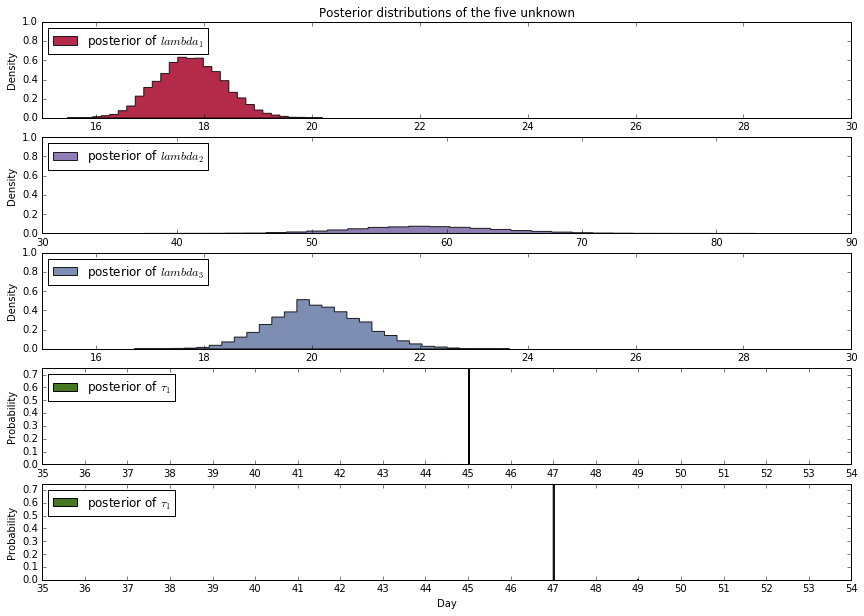

In [18]:
#5つのパラメタの事後分布をプロットする

lambda_1_samples = mcmc.trace('lambda_1')[:]
lambda_2_samples = mcmc.trace('lambda_2')[:]
lambda_3_samples = mcmc.trace('lambda_3')[:]
tau_1_samples = mcmc.trace('tau_1')[:]
tau_2_samples = mcmc.trace('tau_2')[:]

plt.figure(figsize=(14.5, 10))

ax =plt.subplot(511)
ax.set_autoscaley_on(False)
plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85, color="#A60628", normed=True, label="posterior of $lambda_1$")
plt.legend(loc="upper left")

plt.title("Posterior distributions of the five unknown")
plt.xlim([15,30])
plt.xlabel("$\lambda_1$ value")
plt.ylabel("Density")

ax = plt.subplot(512)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85, color="#7A68A6", normed=True, label="posterior of $lambda_2$")
plt.legend(loc="upper left")
plt.xlim([30,90])
plt.xlabel("$\lambda_2$ value")
plt.ylabel("Density")

ax = plt.subplot(513)
ax.set_autoscaley_on(False)
plt.hist(lambda_3_samples, histtype='stepfilled', bins=30, alpha=0.85, color="#687AA6", normed=True, label="posterior of $lambda_3$")
plt.legend(loc="upper left")
plt.xlim([15,30])
plt.xlabel("$\lambda_3$ value")
plt.ylabel("Density")

plt.subplot(514)
w = 1.0 / tau_1_samples.shape[0] * np.ones_like(tau_1_samples)
plt.hist(tau_1_samples, bins=N, alpha=1, label=r"posterior of $\tau_1$", color="#467821", weights=w, rwidth=2.)
plt.xticks(np.arange(N))
plt.legend(loc="upper left")
plt.ylim([0, .75])
plt.xlim([35, len(data) - 20])
plt.xlabel("Day")
plt.ylabel("Probability")

plt.subplot(515)
w = 1.0 / tau_2_samples.shape[0] * np.ones_like(tau_2_samples)
plt.hist(tau_2_samples, bins=N, alpha=1, label=r"posterior of $\tau_1$", color="#467821", weights=w, rwidth=2.)
plt.xticks(np.arange(N))
plt.legend(loc="upper left")
plt.ylim([0, .75])
plt.xlim([35, len(data) - 20])
plt.xlabel("Day")
plt.ylabel("Probability")